In [27]:
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

In [29]:
#loading data
company = 'FB'
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)
data = pdr.DataReader(company,'yahoo',start,end)

In [6]:
#prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [8]:
prediction_days = 60

In [9]:
x_train = []
y_train = []

In [10]:
for x in range(prediction_days,len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [11]:
#building model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
#predicting next closing value
model.add(Dense(units=1))

In [12]:
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
59/59 [==============================] - 24s 148ms/step - loss: 0.0281
Epoch 2/25
59/59 [==============================] - 9s 146ms/step - loss: 0.0054
Epoch 3/25
59/59 [==============================] - 10s 166ms/step - loss: 0.0036
Epoch 4/25
59/59 [==============================] - 10s 166ms/step - loss: 0.0033
Epoch 5/25
59/59 [==============================] - 10s 171ms/step - loss: 0.0036
Epoch 6/25
59/59 [==============================] - 10s 170ms/step - loss: 0.0035
Epoch 7/25
59/59 [==============================] - 10s 170ms/step - loss: 0.0030
Epoch 8/25
59/59 [==============================] - 10s 169ms/step - loss: 0.0032
Epoch 9/25
59/59 [==============================] - 10s 171ms/step - loss: 0.0029
Epoch 10/25
59/59 [==============================] - 10s 177ms/step - loss: 0.0025
Epoch 11/25
59/59 [==============================] - 10s 166ms/step - loss: 0.0034
Epoch 12/25
59/59 [==============================] - 9s 145ms/step - loss: 0.0027
Epoch 13/25
59/

In [14]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://769e421b-ee52-428f-862d-2ed8c56b51ba/assets


INFO:tensorflow:Assets written to: ram://769e421b-ee52-428f-862d-2ed8c56b51ba/assets


In [15]:
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)

In [16]:
#load test data
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = pdr.DataReader(company,'yahoo',test_start,test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']),axis=0)

In [17]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [18]:
#making prediction
x_test = []
for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [19]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

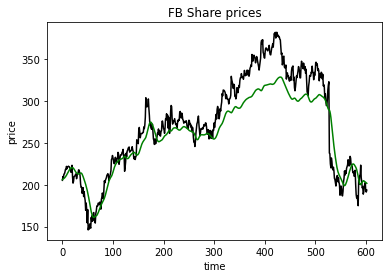

In [30]:
#visualizing
plt.plot(actual_prices,color='black',label=f'actual {company} price')
plt.plot(predicted_prices,color='green',label=f'predicted {company} price')
plt.xlabel('time')
plt.ylabel('price')
plt.title(f'{company} Share prices')
plt.show()